# Домашнее задание №7: "Metric Learning"

**ФИО:** Ковалишин Никита игоревич

**Группа:** ML-22

**Цель задания:** Познакомиться с алгоритмами metric learning

**Описание задания:** В рамках данного домашнего задания предлагается решить задачу поиска похожего автомобиля в базе данных (автомобиля того же класса).

**Что нужно было сделать в домашнем задании:**


0. Выбор модели эмбеддера:
    - Выберите модель кодирующую изображения для выполнения домашнего задания. Любую, кроме модели resnet50.

1. Подготовка обучающего набора данных:
    - Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера);
    - Добавьте аугментации в датасет (0.5 балла).

2. Реализация корректного train-loop и обучение модели:
    - Реализуйте train-loop для вашей модели и проведите обучение c Triplet loss (2 балла);
    - При формировании триплета не просто брать отрицательный класс, а воспользоваться техникой hard negative mining (0.5 балла);
    - Обучите модель и воcпользуйте иными loss функциями для задачи metric learning (0.5 балла).

3. Валидация обученных моделей на тестовой выборке, вычисление метрики Recall и Precision
    - Оцените качество моделей на тестовой части данных и рассчитайте метрики поиска Recall@1, Recall@5, Precision@1, Precision@5. Обратите внимание, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта, а должны производить поиск на основе получившихся эмбеддингов (пример в семинаре блок Faiss), (0.5 балла);
    - При поиске воспользоваться библиотекой Faiss (0.5 балла).

4. Выводы:
    - Проанализируйте результаты обучения, визуально оцените качество работы модели;
    - Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения;
    - Проинтерпретируйте результаты работы модели с помощью GradCam (0.5 балла).


# Подключение необходимых библиотек и вспомогательных функций

In [ ]:
!pip install faiss-gpu
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
import cv2
import os
import faiss
import random
import scipy.io
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from google.colab import drive, output
from torchvision.models import mobilenet_v2
from torchvision.transforms import v2
from torch.utils.data import DataLoader, ConcatDataset
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


def PlotTrainingAndValStatistics(trainLossesLists, valLossesLists, listsLabels, title):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  for i in range(len(listsLabels)):
    plt.plot(trainLossesLists[i], label=listsLabels[i])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Train Loss')
  plt.legend(loc=0, fontsize=16)
  plt.tight_layout()
  plt.grid()

  plt.subplot(1, 2, 2)
  for i in range(len(listsLabels)):
    plt.plot(valLossesLists[i], label=listsLabels[i])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Validation Loss')
  plt.legend(loc=0, fontsize=16)
  plt.tight_layout()
  plt.grid()

  plt.show()

output.clear()

# Загрузка и обзор данных

Распаковка файлов в локальную директорию:

In [ ]:
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/archive.zip'
output.clear()

Загрузка пространства имён и его разметки:

In [ ]:
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fnameToClass = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
carsMeta = scipy.io.loadmat('./devkit/cars_meta.mat')
idToCar = {idx: car[0] for idx, car in enumerate(carsMeta['class_names'][0])}

Визуальный обзор того, что загружено:

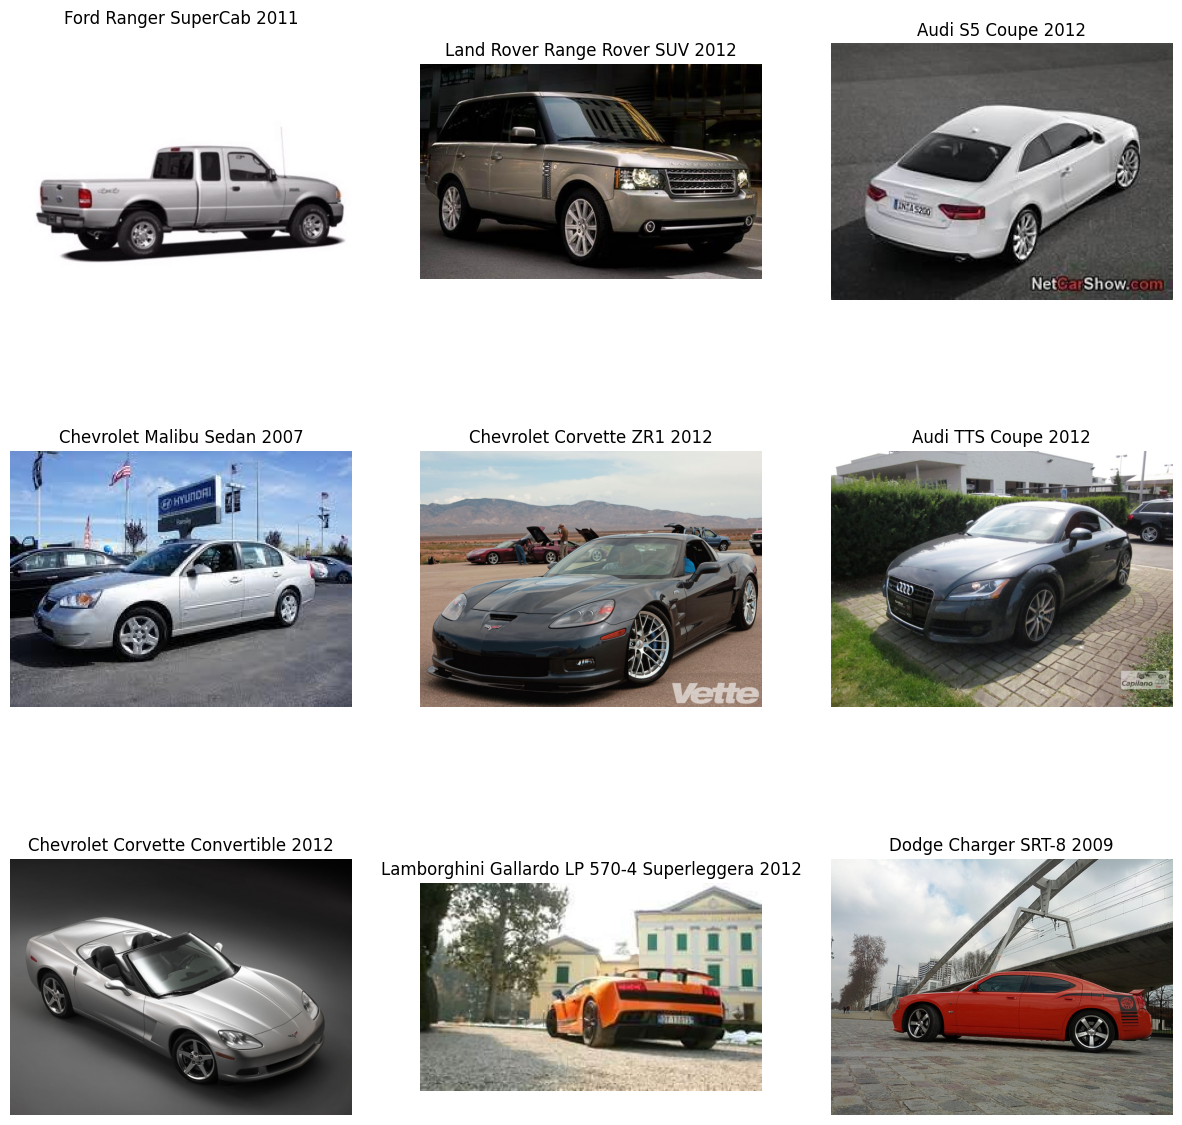

In [ ]:
ADD_PATH = './cars_train/cars_train'
numImgs = 9
cols = 3
rows = numImgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, imIdx in enumerate(random.sample([i for i in range(len(fnameToClass))], numImgs)):
    filename, clId = list(fnameToClass.items())[imIdx]
    tempImage = cv2.imread(os.path.join(ADD_PATH, filename))
    tempImage = cv2.cvtColor(tempImage, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(tempImage)
    ax[idx//cols][idx%cols].set_title(f'{idToCar[clId]}')
    ax[idx//cols][idx%cols].axis('off')

Обзор распределения классов (всего 196 классов автомобилей):

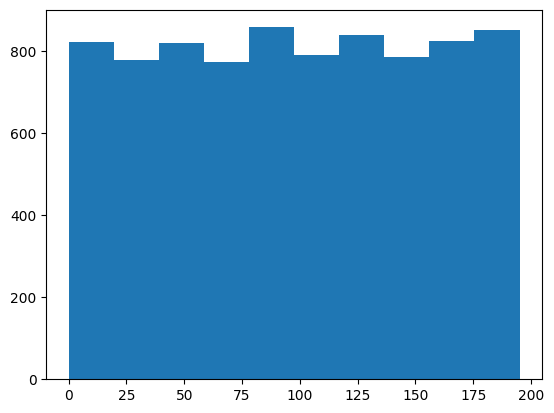

In [ ]:
plt.hist(fnameToClass.values())
plt.show()

# Подготовка данных для обучения

Необходимые трансформации в (т.ч аугментация)

In [ ]:
valTransforms = v2.Compose([
                            v2.ToImage(),
                            v2.Resize(size=(224, 224)),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]
                                        )
                           ])

augTransforms = v2.Compose([
                            v2.ToImage(),
                            v2.RandomResizedCrop(size=(224, 224), scale=(0.95, 1.0)), #небольшой кроп по краям
                            v2.RandomHorizontalFlip(p = 1.0),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)), # мелкие артефакты
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomErasing(p=0.8, scale=(0.002, 0.002)),
                            v2.RandomRotation(15), #небольшие повороты
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]
                                        )
                           ])

Класс Dataset'а:

In [ ]:
class CropClassifDataset(torch.utils.data.Dataset):
  def __init__(self, carsItems, transforms):
    self.cars = carsItems
    self.transforms = transforms

  def __len__(self):
    return len(self.cars)

  def __getitem__(self, idx):
    filename, clId = self.cars[idx]
    image = cv2.imread(os.path.join(ADD_PATH, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if self.transforms:
      image = self.transforms(image)
    sample = {'image': image, 'label': clId}
    return sample

Класс Center Loss:

In [ ]:
#Реализуется простейший Center Loss для задачи Metric Learning.
class CenterLoss(nn.Module):
  def __init__(self, numClasses=10, featDim=2, device='cpu'):
    super(CenterLoss, self).__init__()
    self.numClasses = numClasses
    self.featDim = featDim
    #В нашем случае центроиды лежат на поверхности единичной гиперсферы (из-за нормализации данных).
    #В общем случае можно добавить опцию для ненормализованных данных.
    self.centers = nn.Parameter(nn.functional.normalize(torch.randn(self.numClasses, self.featDim).to(device)))

  def forward(self, x, labels):
    batchSize = x.size(0)
    distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batchSize, self.numClasses) + \
              torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.numClasses, batchSize).t()
    distmat.addmm_(1, -2, x, self.centers.t())
    classes = torch.arange(self.numClasses).long()
    classes = classes.to(device)
    labels = labels.unsqueeze(1).expand(batchSize, self.numClasses)
    mask = labels.eq(classes.expand(batchSize, self.numClasses))
    dist = distmat * mask.float()
    loss = dist.clamp(min=1e-12, max=1e+12).sum() / batchSize
    return loss

Класс Triplet Loss (на евклидовом расстоянии):

In [ ]:
#Реализуется TripletLoss(A, P, N) = max(0, d(A, P) - d(A, N) + margin).
#Этот Loss учитывает только semi-hard и hard негативы из-за max(0, ...).
#Так что hard negative mining здесь в целом присутствует.
class TripletLossEuclid(nn.Module):

  def __init__(self, margin, epsilon=1e-6):
    super(TripletLossEuclid, self).__init__()
    self.margin = margin
    self.epsilon = epsilon

#Цель forward - векторизовать, но избежать трёхмерных матриц.
  def forward(self, x, labels):
    batchSize = x.size(0)
    scalarSqValues = torch.sum(x**2, dim=1)
    colExScalarSqValues = torch.sum(x**2, dim=1).expand(batchSize, batchSize)
    colExLabels = labels.expand(batchSize, batchSize)
    maskNeg = ~(colExLabels.eq(colExLabels.t()))
    #Половину позитив маски зануляем, т.к. триплеты (x1, x2, ..) ~ (x2, x1, ..)
    maskPosit = (~maskNeg).triu(diagonal=1)
    rowExAnchIds = torch.arange(batchSize,
                                device=x.device).unsqueeze(dim=1).expand(batchSize, batchSize)
    anchPositIds = rowExAnchIds[maskPosit]
    scalarSqAnchVals = scalarSqValues[anchPositIds]
    scalarSqAnchPositVals = colExScalarSqValues[maskPosit] + scalarSqAnchVals
    maskNegForAnchPosit = maskNeg[anchPositIds]
    colExAnchNegScalarSq = colExScalarSqValues[anchPositIds] + \
                           scalarSqAnchVals.unsqueeze(dim=1).expand(anchPositIds.size(0),
                                                                    batchSize)
    rowExAnchPositScalarSq = scalarSqAnchPositVals.unsqueeze(dim=1).expand(anchPositIds.size(0),
                                                                           batchSize)
    anchCandidateComp = x @ x.t()
    anchPositiveComp = anchCandidateComp[maskPosit].unsqueeze(dim=1)
    rowExAnchPositComp = anchPositiveComp.expand(anchPositIds.size(0), batchSize)
    anchNegComp = anchCandidateComp[anchPositIds]
    result = torch.sqrt(rowExAnchPositScalarSq - 2 * rowExAnchPositComp + self.epsilon) - \
             torch.sqrt(colExAnchNegScalarSq - 2 * anchNegComp + self.epsilon)
    lossTensor = (result + self.margin) * maskNegForAnchPosit
    lossTensor = lossTensor * (lossTensor > 0) # здесь учёт semi-hard и hard
    return torch.sum(lossTensor) / (torch.count_nonzero(lossTensor) + self.epsilon)

Создание обёрток-датасетов над пространством имён и метками:

In [ ]:
items = list(fnameToClass.items())
random.shuffle(items)
trainItems = items[:int(len(items) * 0.8)]
valItems = items[int(len(items) * 0.8):]
trainDatasetOrig = CropClassifDataset(trainItems, valTransforms)
trainDatasetAug = CropClassifDataset(trainItems, augTransforms)
trainDatasetWthAug = ConcatDataset([trainDatasetOrig, trainDatasetAug])
valDataset = CropClassifDataset(valItems, valTransforms)

Создание Data Loader'ов:

In [ ]:
trainLoaderOrig = DataLoader(trainDatasetOrig,
                             batch_size=383,
                             shuffle=True,
                             num_workers=12,
                             collate_fn=None,
                             pin_memory=True,
                             drop_last = True)
trainLoaderWthAug = DataLoader(trainDatasetAug,
                               batch_size=383,
                               shuffle=True,
                               num_workers=12,
                               collate_fn=None,
                               pin_memory=True,
                               drop_last = True)
valLoader = DataLoader(valDataset,
                       batch_size=407,
                       shuffle=False,
                       num_workers=4,
                       collate_fn=None,
                       pin_memory=True)

# Реализация инструментов для обучения

Создание класса-обёртки над моделью MobileNet, который меняет его голову:

In [ ]:
class MobileNetL2(nn.Module):

  def __init__(self, embedDim):
    super(MobileNetL2, self).__init__()
    self.model = mobilenet_v2(weights='IMAGENET1K_V1')
    self.model.classifier = nn.Linear(self.model.last_channel, embedDim)

  def forward(self, x):
    x = self.model(x)
    x = nn.functional.normalize(x) # нормализация embedding'ов
    return x

Реализация Train Loop с валидационной проверкой:

In [ ]:
def MetricLearningTrain(model, trainLoader, valLoader, loss, optimizer, device, epochs=100):
  model.to(device)
  model.train()
  trainLossLst = []
  valLossLst = []
  for epoch in range(epochs):
    epochTrainLoss, epochValLoss = 0. , 0.
    for batchItem in trainLoader:
      images = batchItem['image'].to(device)
      labels = batchItem['label'].to(device)
      embeddings = model(images)
      lossResult = loss(embeddings, labels)
      epochTrainLoss += lossResult.item()
      optimizer.zero_grad()
      lossResult.backward()
      optimizer.step()
    trainLossLst += [epochTrainLoss / len(trainLoader)]
    print(f"Epoch {epoch} train loss = {trainLossLst[-1]}")
    model.eval()
    with torch.no_grad():
      for batchItem in valLoader:
        images = batchItem['image'].to(device)
        labels = batchItem['label'].to(device)
        embeddings = model(images)
        lossResult = loss(embeddings, labels)
        epochValLoss += lossResult.item()
    valLossLst += [epochValLoss / len(valLoader)]
    print(f"Epoch {epoch} val loss = {valLossLst[-1]}")
  model.to('cpu')
  return trainLossLst, valLossLst

# Обучение моделей с помощью Center Loss

Предисловие.

Размерность подобрана достаточно аккуратно, но в нашем случае лучше этим сильно не увлекаться. С большими размерностями embedding'ов есть куча проблем, связанных с нестабильностью обучения. Для евклидовых метрик близости большие размерности это особая боль, а они и используются в наших реализациях функций потерь. Поэтому ограничимся средними размерностями.

Инициализация устройства:

In [ ]:
device = 'cuda'

Инициализация объекта Center Loss:

In [ ]:
centerLoss = CenterLoss(numClasses=len(idToCar), featDim=50, device=device)

Создание и обучение модели с помощью функции потерь Center Loss на датасете без аугментаций:

In [ ]:
modelCLOrig = MobileNetL2(50)
optimizerCLOrig = torch.optim.Adam(modelCLOrig.parameters(), lr=1e-4)
trainOrigCLLosses, valOrigCLLosses = MetricLearningTrain(modelCLOrig,
                                                         trainLoaderOrig,
                                                         valLoader,
                                                         centerLoss,
                                                         optimizerCLOrig,
                                                         device,
                                                         epochs=25)
output.clear()

Создание и обучение модели с помощью функции потерь Center Loss на датасете c аугментациями:

In [ ]:
modelCLAug = MobileNetL2(50)
optimizerCLAug = torch.optim.Adam(modelCLAug.parameters(), lr=1e-4)
trainAugCLLosses, valAugCLLosses = MetricLearningTrain(modelCLAug,
                                                       trainLoaderWthAug,
                                                       valLoader,
                                                       centerLoss,
                                                       optimizerCLAug,
                                                       device,
                                                       epochs=25)
output.clear()

Вывод статистик обучения моделей, обученных с помощью функции потерь Center Loss:

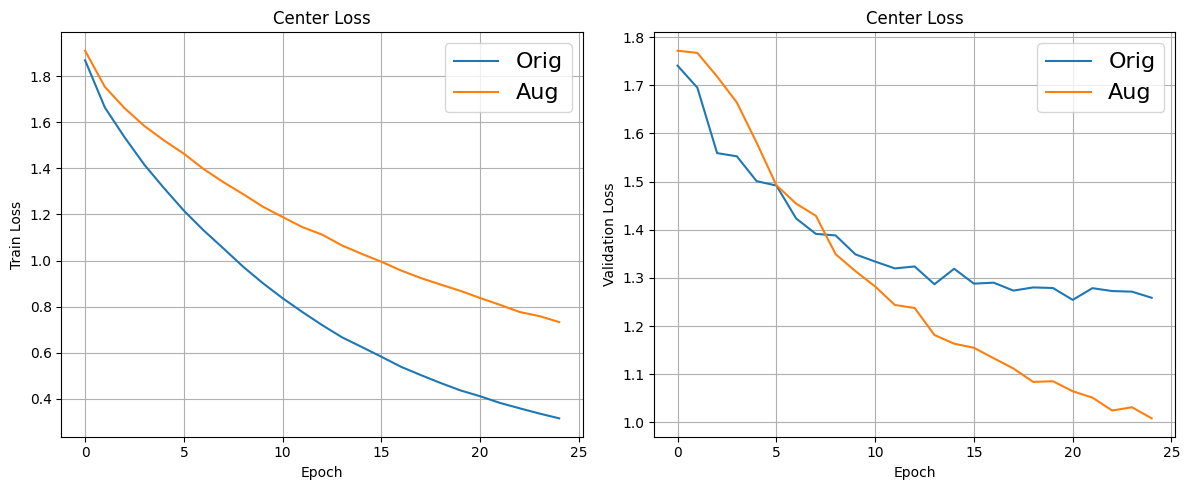

In [ ]:
PlotTrainingAndValStatistics([trainOrigCLLosses, trainAugCLLosses], [valOrigCLLosses, valAugCLLosses], ['Orig', 'Aug'], 'Center Loss')

Выводы по обучению с помощью Center Loss.

Видно, что аугментации помогли. Но количество итераций было подобрано специально таким образом, чтобы остановить обучение тогда, когда модель стала сильно адаптироваться под частные закономерности тренировочного датасета.

# Обучение с помощью Triplet Loss

Инициализация объекта Triplet Loss:

In [ ]:
lossTrp = TripletLossEuclid(0.3) #margin = 0.3

Создание и обучение модели с помощью функции потерь Triplet Loss на датасете без аугментаций:

In [ ]:
modelTrpOrig = MobileNetL2(50) #embeddings dimension = 50
optimizerTrpOrig = torch.optim.Adam(modelTrpOrig.parameters(), lr=3e-4)
trainOrigTLosses, valOrigTLosses = MetricLearningTrain(modelTrpOrig,
                                                       trainLoaderOrig,
                                                       valLoader,
                                                       lossTrp,
                                                       optimizerTrpOrig,
                                                       device)
output.clear()

Создание и обучение модели с помощью функции потерь Triplet Loss на датасете c аугментациями:

In [ ]:
modelTrpAug = MobileNetL2(50)
optimizerTrpAug = torch.optim.Adam(modelTrpAug.parameters(), lr=3e-4)
trainAugTLosses, valAugTLosses = MetricLearningTrain(modelTrpAug,
                                                     trainLoaderWthAug,
                                                     valLoader,
                                                     lossTrp,
                                                     optimizerTrpAug,
                                                     device)
output.clear()

Вывод статистик обучения моделей, обученных с помощью функции потерь Triplet Loss:

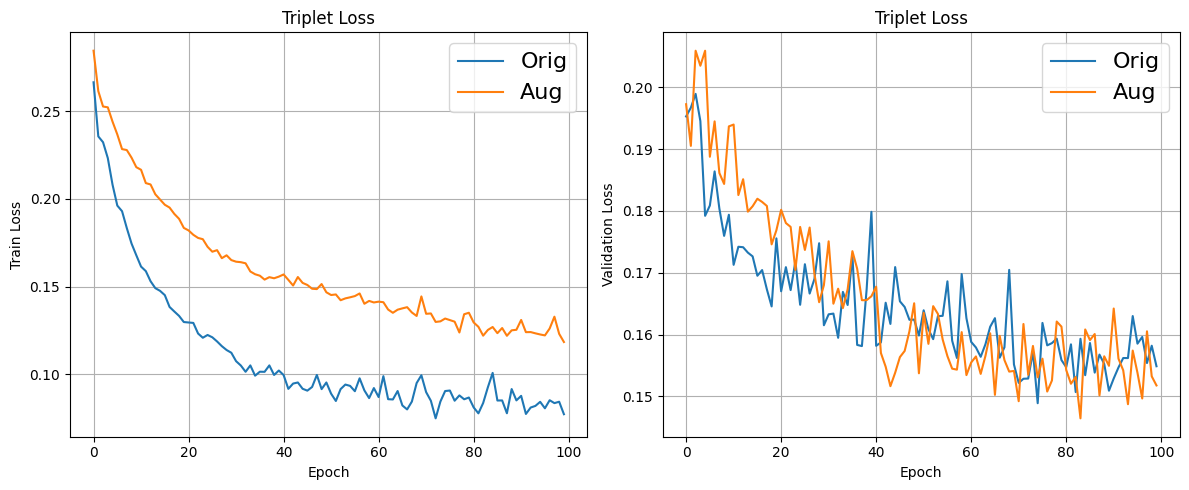

In [ ]:
PlotTrainingAndValStatistics([trainOrigTLosses, trainAugTLosses],
                             [valOrigTLosses, valAugTLosses],
                             ['Orig', 'Aug'],
                             'Triplet Loss')

Выводы по обучению с помощью Triplet Loss.

Визуально трудно понять, помогли ли аугментации или нет. На мой взгляд, немного помогли. Но хуже они точно не сделали. Всё станет ясно, когда будут вычислены метрики качества.

# Метрики качества Precision@K и Recall@K

Функции для расчёта метрик качества Precision@K и Recall@K

In [ ]:
def GetEmbeds(model, loader):
  embeddings = np.empty((1,50))
  labels = np.empty((1))
  for batch in loader:
    imgs = batch['image']
    label = batch['label']
    with torch.no_grad():
      preds = model(imgs.to(device))
    embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
    labels = np.concatenate([labels, label.numpy()])
  return embeddings[1:].astype(np.float32), labels[1:]

def GetPrecisionRecallK(model, queryLoader, nghbrLoader, K, embeddingSize, device, toCPUAfterCalcEmbeds=False):
  index = faiss.IndexFlatL2(embeddingSize)
  model.eval()
  model.to(device)
  queryEmbs, queryLabels = GetEmbeds(model, queryLoader)
  nghbrEmbs, nghbrLabels = GetEmbeds(model, nghbrLoader)
  if toCPUAfterCalcEmbeds:
    model.to('cpu')
  index.add(nghbrEmbs)
  _, nghbrIndexes = index.search(queryEmbs, K)
  queryCount = queryLabels.shape[0]
  #Далее спорная ситуация, можно с циклом посчитать, а можно без него.
  #Если кол-во запросов и общее кол-во соседей не огромные, то лучше векторизованный вариант.
  #Для данного ДЗ он пойдёт, максимальный размер ОЗУ будет использован ~36 МБ.
  queryLabelsExNghbr = np.broadcast_to(queryLabels.reshape(queryLabels.shape[0], 1),
                                        (queryLabels.shape[0], nghbrLabels.shape[0]))
  nghbrLabelsExQuery = np.broadcast_to(nghbrLabels,
                                        (queryLabels.shape[0], nghbrLabels.shape[0]))
  allNghbrCounts = np.sum(queryLabelsExNghbr == nghbrLabelsExQuery, axis=1).ravel()
  queryLabelsExNghbrK = np.broadcast_to(queryLabels.reshape(queryLabels.shape[0], 1),
                                        (queryLabels.shape[0], K))
  nghbrLabelsK = nghbrLabels[nghbrIndexes.ravel()].reshape(queryCount, K)
  correctNghbrsCounts = np.sum(queryLabelsExNghbrK == nghbrLabelsK, axis=1).ravel()
  precisionK = np.mean(correctNghbrsCounts / K)
  recallK = np.mean(correctNghbrsCounts / allNghbrCounts)
  return precisionK, recallK

Расчёт метрик качества Precision@1 и Recall@1 и Precision@5 и Recall@5 для разных моделей:

In [ ]:
#Precision@1, Recall@1, Precision@5, Recall@5 необученной модели по Metric Learning схеме:

prNonTrainedModel1, rcNonTrainedModel1 = GetPrecisionRecallK(MobileNetL2(50),
                                                             valLoader,
                                                             trainLoaderOrig,
                                                             1,
                                                             50,
                                                             'cuda',
                                                             True)
prNonTrainedModel5, rcNonTrainedModel5 = GetPrecisionRecallK(MobileNetL2(50),
                                                             valLoader,
                                                             trainLoaderOrig,
                                                             5,
                                                             50,
                                                             'cuda',
                                                             True)

#Precision@1, Recall@1, Precision@5, Recall@5 модели,
#обученной на оригинальных данных с CenterLoss:

prCLTrainedOrigModel1, rcCLTrainedOrigModel1 = GetPrecisionRecallK(modelCLOrig,
                                                                   valLoader,
                                                                   trainLoaderOrig,
                                                                   1,
                                                                   50,
                                                                   'cuda',
                                                                   True)
prCLTrainedOrigModel5, rcCLTrainedOrigModel5 = GetPrecisionRecallK(modelCLOrig,
                                                                   valLoader,
                                                                   trainLoaderOrig,
                                                                   5,
                                                                   50,
                                                                   'cuda',
                                                                   True)

#Precision@1, Recall@1, Precision@5, Recall@5 модели,
#обученной на оригинальных + аугментированных данных с CenterLoss:

prCLTrainedAugModel1, rcCLTrainedAugModel1 = GetPrecisionRecallK(modelCLAug,
                                                                 valLoader,
                                                                 trainLoaderOrig,
                                                                 1,
                                                                 50,
                                                                 'cuda',
                                                                 True)
prCLTrainedAugModel5, rcCLTrainedAugModel5 = GetPrecisionRecallK(modelCLAug,
                                                                 valLoader,
                                                                 trainLoaderOrig,
                                                                 5,
                                                                 50,
                                                                 'cuda',
                                                                 True)

#Precision@1, Recall@1, Precision@5, Recall@5 модели,
#обученной на оригинальных данных с TripletLoss:

prTrpTrainedOrigModel1, rcTrpTrainedOrigModel1 = GetPrecisionRecallK(modelTrpOrig,
                                                                     valLoader,
                                                                     trainLoaderOrig,
                                                                     1,
                                                                     50,
                                                                     'cuda',
                                                                     True)
prTrpTrainedOrigModel5, rcTrpTrainedOrigModel5 = GetPrecisionRecallK(modelTrpOrig,
                                                                     valLoader,
                                                                     trainLoaderOrig,
                                                                     5,
                                                                     50,
                                                                     'cuda',
                                                                     True)

#Precision@1, Recall@1, Precision@5, Recall@5 модели,
#обученной на оригинальных + аугментированных данных с TripletLoss:

prTrpTrainedAugModel1, rcTrpTrainedAugModel1 = GetPrecisionRecallK(modelTrpAug,
                                                                   valLoader,
                                                                   trainLoaderOrig,
                                                                   1,
                                                                   50,
                                                                   'cuda',
                                                                   True)
prTrpTrainedAugModel5, rcTrpTrainedAugModel5 = GetPrecisionRecallK(modelTrpAug,
                                                                   valLoader,
                                                                   trainLoaderOrig,
                                                                   5,
                                                                   50,
                                                                   'cuda',
                                                                   True)

Вывод метрик качества Precision@1 и Recall@1 и Precision@5 и Recall@5 для разных моделей:

In [ ]:
print("------------------------------------------------------------------------------")
print("Precision@1, Recall@1, Precision@5, Recall@5 of non-trained model:")
print("------------------------------------------------------------------------------")
print("Precision@1: ", prNonTrainedModel1)
print("Recall@1: ", rcNonTrainedModel1)
print("Precision@5: ", prNonTrainedModel5)
print("Recall@5: ", rcNonTrainedModel5)
print("------------------------------------------------------------------------------")
print("")
print("------------------------------------------------------------------------------")
print("Precision@1, Recall@1, Precision@5, Recall@5 of orig trained model with CL:")
print("------------------------------------------------------------------------------")
print("Precision@1: ", prCLTrainedOrigModel1)
print("Recall@1: ", rcCLTrainedOrigModel1)
print("Precision@5: ", prCLTrainedOrigModel5)
print("Recall@5: ", rcCLTrainedOrigModel5)
print("------------------------------------------------------------------------------")
print("")
print("------------------------------------------------------------------------------")
print("Precision@1, Recall@1, Precision@5, Recall@5 of aug trained model with CL:")
print("------------------------------------------------------------------------------")
print("Precision@1: ", prCLTrainedAugModel1)
print("Recall@1: ", rcCLTrainedAugModel1)
print("Precision@5: ", prCLTrainedAugModel5)
print("Recall@5: ", rcCLTrainedAugModel5)
print("------------------------------------------------------------------------------")
print("")
print("------------------------------------------------------------------------------")
print("Precision@1, Recall@1, Precision@5, Recall@5 of orig trained model with TL:")
print("------------------------------------------------------------------------------")
print("Precision@1: ", prTrpTrainedOrigModel1)
print("Recall@1: ", rcTrpTrainedOrigModel1)
print("Precision@5: ", prTrpTrainedOrigModel5)
print("Recall@5: ", rcTrpTrainedOrigModel5)
print("------------------------------------------------------------------------------")
print("")
print("------------------------------------------------------------------------------")
print("Precision@1, Recall@1, Precision@5, Recall@5 of aug trained model with TL:")
print("------------------------------------------------------------------------------")
print("Precision@1: ", prTrpTrainedAugModel1)
print("Recall@1: ", rcTrpTrainedAugModel1)
print("Precision@5: ", prTrpTrainedAugModel5)
print("Recall@5: ", rcTrpTrainedAugModel5)
print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
Precision@1, Recall@1, Precision@5, Recall@5 of non-trained model:
------------------------------------------------------------------------------
Precision@1:  0.13627992633517497
Recall@1:  0.004230527113179997
Precision@5:  0.07857581338244321
Recall@5:  0.012062006920238224
------------------------------------------------------------------------------

------------------------------------------------------------------------------
Precision@1, Recall@1, Precision@5, Recall@5 of orig trained model with CL:
------------------------------------------------------------------------------
Precision@1:  0.3314917127071823
Recall@1:  0.010077530649366792
Precision@5:  0.31761817065684467
Recall@5:  0.04826297648586114
------------------------------------------------------------------------------

------------------------------------------------------------------------------
Precision@1, Recall@1, Precision@5, Reca

В целом можно сказать, что метрики качества проявили себя ожидаемо.

1) На не обученной модели по Metric Learning схеме получены самые низкие результаты.

2) На модели, обученной с помощью Center Loss, результаты улучшились значительно. Более того, аугментация дала ощутимый прирост.

3) На модели, обученной с помощью Triplet Loss, показаны самые лучшие результаты метрики качества. Аугментация дала некоторый прирост.

По поводу **Recall@k** скажу сразу. Он может быть маленьким, если число ***k*** соседей, которых мы выбираем, будет много меньше ***K***.

***K*** - число всех объектов из датасета **D**, которые реально являются соседами,

**D** - датасет, откуда выбирается ***k*** соседей для данного объекта.

# GradCam с embedding'ами

In [ ]:
transformToShow = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(),
                        torchvision.transforms.Resize(
                           size= (224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def GetImageFromPath(path):
  origIm = np.array(Image.open(path).convert('RGB'))
  rgbIm = np.array(transformToShow(origIm).permute(1,2,0))
  transformedIm = valTransforms(origIm).unsqueeze(0)
  origIm = cv2.resize(origIm, (512, 512))
  return origIm, rgbIm, transformedIm

In [ ]:
carImg, carImgFloat, carTensor = GetImageFromPath("./cars_test/cars_test/00001.jpg")
carConceptFeatures = modelTrpAug(carTensor)[0, :]

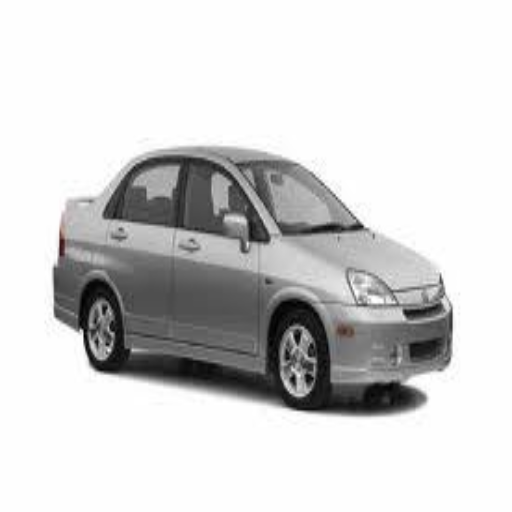

In [ ]:
Image.fromarray(carImg)

In [ ]:
image1, imageFloat1, inputTensor1 = GetImageFromPath("./cars_test/cars_test/00002.jpg")
image2, imageFloat2, inputTensor2 = GetImageFromPath("./cars_test/cars_test/00003.jpg")
image3, imageFloat3, inputTensor3 = GetImageFromPath("./cars_test/cars_test/00004.jpg")
image4, imageFloat4, inputTensor4 = GetImageFromPath("./cars_test/cars_test/00005.jpg")
image5, imageFloat5, inputTensor5 = GetImageFromPath("./cars_test/cars_test/00006.jpg")

In [ ]:
class SimilarityToConceptTarget:
  def __init__(self, features):
    self.features = features

  def __call__(self, modelOutput):
    cos = torch.nn.CosineSimilarity(dim=0)
    return cos(modelOutput, self.features)

targetLayers = [modelTrpAug.model.features[-1]]#выбираем самую результативную модель
carTargets = [SimilarityToConceptTarget(carConceptFeatures)]

def VisualizeZones(model, targetLayers, inputTensor, similarityTargets, imageFloat):
  with GradCAM(model=model, target_layers=targetLayers) as cam:
    carGrayscaleCam = cam(input_tensor=inputTensor, targets=similarityTargets)[0, :]
  carCamImage = show_cam_on_image(imageFloat, carGrayscaleCam, use_rgb=True)
  return carCamImage

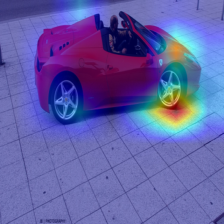

In [ ]:
Image.fromarray(VisualizeZones(modelTrpAug, targetLayers, inputTensor1, carTargets, imageFloat1))

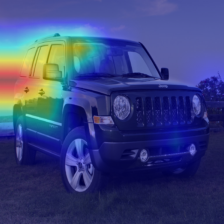

In [ ]:
Image.fromarray(VisualizeZones(modelTrpAug, targetLayers, inputTensor2, carTargets, imageFloat2))

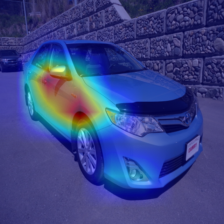

In [ ]:
Image.fromarray(VisualizeZones(modelTrpAug, targetLayers, inputTensor3, carTargets, imageFloat3))

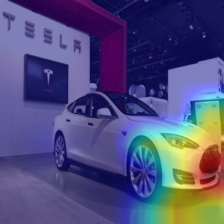

In [ ]:
Image.fromarray(VisualizeZones(modelTrpAug, targetLayers, inputTensor4, carTargets, imageFloat4))

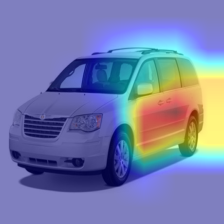

In [ ]:
Image.fromarray(VisualizeZones(modelTrpAug, targetLayers, inputTensor5, carTargets, imageFloat5))

Выводы по визуализации зон внимания модели.

В целом можно сказать, что модель MobileNet, обученная на Triplet Loss, выделяет такие паттерны автомобилей как бамперы, боковые двери, колесо. Но по отдельным картинкам можно увидеть, что зоны внимания не совсем чёткие, и будто немного сдвинуты. Это говорит о том, что модель в чём-то не особо уверенна, и заранее выделяет области побольше.

Отчасти это можно назвать следствием online-аугментации, которая специально не даёт модели быть через-чур уверенной в каких-то частных закономерностях тренировочного датасета. Но если перебрать с аугментациями, то и какая-то часть общих закономерностей будет отброшена.

Что можно было бы явно улучшить? Есть какие-то непонятные смещения возле областей, где есть тени (изображения 1 и 4). Это нехорошо, так как если модель начинает обращать внимание на тень, то это явно будет её запутывать на валидации. Поэтому стоило бы добавить аугментацию, которая убирала бы влияние теней. Это могут быть манипуляции с контрастсностью и яркостью.